# Comparison between variant annotation databases

Created: **31/07/18**  
Last modified: **07/08/18**

**Goal:** ...  
This notebook is divided in ? parts:

See [`doc/biblio/variant_annotation_databases.md`](https://github.com/ElsaB/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md) for detailed documentation of all these databases.

* **1. Bla**: Bla

**Refs:**
* `annotating.ipynb` [Pierre]
* `custom_tools.R` [Pierre](./annotating.ipynb)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CIViC" data-toc-modified-id="CIViC-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CIViC</a></span><ul class="toc-item"><li><span><a href="#Get-the-raw-data" data-toc-modified-id="Get-the-raw-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get the raw data</a></span></li><li><span><a href="#Create-keys-to-join-the-two-dataframes-and-extract-the-features" data-toc-modified-id="Create-keys-to-join-the-two-dataframes-and-extract-the-features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create keys to join the two dataframes and extract the features</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Cancer-Genome-Interpreter" data-toc-modified-id="Cancer-Genome-Interpreter-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cancer Genome Interpreter</a></span><ul class="toc-item"><li><span><a href="#Get-the-raw-data" data-toc-modified-id="Get-the-raw-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get the raw data</a></span></li><li><span><a href="#Create-keys-to-join-the-two-dataframes-and-extract-the-features" data-toc-modified-id="Create-keys-to-join-the-two-dataframes-and-extract-the-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Create keys to join the two dataframes and extract the features</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Precision-Medicine-Knowledgebase" data-toc-modified-id="Precision-Medicine-Knowledgebase-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Precision Medicine Knowledgebase</a></span></li><li><span><a href="#https://ckb.jax.org/about/index" data-toc-modified-id="https://ckb.jax.org/about/index-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><a href="https://ckb.jax.org/about/index" target="_blank">https://ckb.jax.org/about/index</a></a></span></li><li><span><a href="#Others" data-toc-modified-id="Others-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Others</a></span></li></ul></div>

***

In [29]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [30]:
impact <- get_cleaned_impact("../../../data")
impact <- add_features("../../../data", impact, oncokb = TRUE)

Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 1 has 248365 rows to replace 248350 rows”Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 2 has 248365 rows to replace 248350 rows”Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 3 has 248365 rows to replace 248350 rows”

We will study different databases available online and compare them with OncoKB:
* [CIViC](https://civicdb.org/)
* [Cancer Genome Interpreter](https://www.cancergenomeinterpreter.org/home)
* [MyCancerGenome](https://www.mycancergenome.org)
* Others:
    * Bla
    * Bla

## CIViC

### Get the raw data

Data downloaded from https://civicdb.org/releases under "Variant Summaries", 01/07/18 version.

In [31]:
civic <- read.table("../../../data/other_databases/CIViC_01-Jul-2018-VariantSummaries.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [32]:
nrow(civic)
length(unique(civic$gene))
colnames(civic)

[1] 1885

[1] 353

In [34]:
interesting_columns <- c(
"gene",
"variant",
"chromosome",
"start",
"stop",
"reference_bases",
"variant_bases",
"representative_transcript",
"ensembl_version",
"reference_build",
"variant_types",
"hgvs_expressions",
"civic_actionability_score")

head(civic[, interesting_columns], 10)

gene,variant,chromosome,start,stop,reference_bases,variant_bases,representative_transcript,ensembl_version,reference_build,variant_types,hgvs_expressions,civic_actionability_score
ABL1,BCR-ABL,22,23522397,23632600,,,ENST00000305877.8,75,GRCh37,transcript_fusion,,238.0
ABL1,BCR-ABL T334I,9,133748283,133748283,C,T,ENST00000372348.2,75,GRCh37,"transcript_fusion,missense_variant","NM_007313.2:c.1001C>T,NP_005148.2:p.Thr315Ile,ENST00000372348.2:c.1001C>T,NC_000009.11:g.133748283C>T",54.0
ABL1,BCR-ABL E255K,9,133738363,133738363,G,A,ENST00000318560.5,75,GRCh37,"transcript_fusion,missense_variant","NC_000009.11:g.133738363G>A,NM_005157.5:c.763G>A,NP_005148.2:p.Glu255Lys,ENST00000318560.5:c.763G>A",17.0
AKT1,E17K,14,105246551,105246551,C,T,ENST00000407796.2,75,GRCh37,missense_variant,"NC_000014.8:g.105246551C>T,NM_001014432.1:c.49G>A,NP_001014432.1:p.Glu17Lys,ENST00000407796.2:c.49G>A",32.5
ALK,EML4-ALK,2,42396490,42522656,,,ENST00000318522.5,75,GRCh37,transcript_fusion,,48.0
ALK,EML4-ALK C1156Y,2,29445258,29445258,C,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3467G>A,NC_000002.11:g.29445258C>T,NM_004304.4:c.3467G>A,NP_004295.2:p.Cys1156Tyr",19.0
ALK,EML4-ALK L1196M,2,29443631,29443631,G,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3586C>A,NC_000002.11:g.29443631G>T,NM_004304.4:c.3586C>A,NP_004295.2:p.Leu1196Met",31.0
ALK,F1174L,2,29443695,29443695,G,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3522C>A,NP_004295.2:p.Phe1174Leu,NC_000002.11:g.29443695G>T,ENST00000389048.3:c.3522C>A",33.5
ALK,R1275Q,2,29432664,29432664,C,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3824G>A,NP_004295.2:p.Arg1275Gln,NC_000002.11:g.29432664C>T,ENST00000389048.3:c.3824G>A",23.0
ARAF,S214C,X,47426121,47426121,C,G,ENST00000377045.4,75,GRCh37,missense_variant,"NC_000023.10:g.47426121C>G,NM_001654.4:c.641C>G,NP_001645.1:p.Ser214Cys,ENST00000377045.4:c.641C>G",11.0


### Create keys to join the two dataframes and extract the features

We will join the database using the following keys: 
* `mut_key` for `impact`
* `chromosome`\_`start`_`reference_bases`_`variant_bases` for `civic`

In [35]:
civic$join_key <- paste(civic$chromosome, civic$start, civic$reference_bases, civic$variant_bases, sep = "_")
civic$join_key[civic$chromosome == "" |
               civic$start == "" |
               (civic$reference_bases == "" & civic$variant_bases   == "")] <- "no_key"

In [37]:
print_count_and_proportion(civic[civic$join_key == "no_key",], civic)

# delete the rows where we couldn't compute a key
civic <- civic[civic$join_key != "no_key",]

[1] "0 over 803 (0.00%)"

**Verification 1** The `join_key` are not unique:

In [38]:
length(unique(civic$join_key))
nrow(civic)

repeated_key <- civic %>% group_by(join_key) %>% filter(n() > 1)
repeated_key[order(repeated_key$join_key), interesting_columns]

[1] 797

[1] 803

gene,variant,chromosome,start,stop,reference_bases,variant_bases,representative_transcript,ensembl_version,reference_build,variant_types,hgvs_expressions,civic_actionability_score
FLT3,TKD MUTATION,13,28592642,28592642,C,A,ENST00000241453.7,75,GRCh37,nonsynonymous_variant,NC_000013.10:g.28592642C>A,120.0
FLT3,D835,13,28592642,28592642,C,A,ENST00000241453.7,75,GRCh37,protein_altering_variant,NC_000013.10:g.28592642C>A,46.0
ERBB2,P780INS,17,37881011,37881012,,GGCTCCCCA,ENST00000269571.5,75,GRCh37,inframe_insertion,"ENST00000269571.5:c.2340_2341insGGCTCCCCA,NC_000017.10:g.37881011_37881012insGGCTCCCCA",12.5
ERBB2,G778_P780DUP,17,37881011,37881012,,GGCTCCCCA,ENST00000269571.5,75,GRCh37,inframe_insertion,NM_004448.3:c.2332_2340dupGGCTCCCCA,15.0
ALK,EML4-ALK G1269A,2,29432682,29432682,C,G,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3806G>C,NC_000002.11:g.29432682C>G,NM_004304.4:c.3806G>C,NP_004295.2:p.Gly1269Ala",17.5
ALK,ALK FUSION G1269A,2,29432682,29432682,C,G,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3806G>C,NC_000002.11:g.29432682C>G,NM_004304.4:c.3806G>C,NP_004295.2:p.Gly1269Ala",10.0
ALK,F1245C,2,29436859,29436859,A,C,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3734T>G,NP_004295.2:p.Phe1245Cys,NC_000002.11:g.29436859A>C,ENST00000389048.3:c.3734T>G",10.5
ALK,ALK FUSION F1245C,2,29436859,29436859,A,C,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","NM_004304.4:c.3734T>G,NP_004295.2:p.Phe1245Cys,NC_000002.11:g.29436859A>C,ENST00000389048.3:c.3734T>G",14.5
VHL,P59fs (c.173_174insC),3,10183704,10183705,,C,ENST00000256474.2,75,GRCh37,frameshift_truncation,"ENST00000256474.2:c.173_174insC,NP_000542.1:p.Pro59AlafsTer73,NM_000551.3:c.173_174insC,NC_000003.11:g.10183704_10183705insC",7.5
VHL,R58fs (c.173_174insC),3,10183704,10183705,,C,ENST00000256474.2,75,GRCh37,frameshift_variant,ENST00000256474.2:c.173_174insC,0.0


In [39]:
# delete the repeated keys
civic <- civic[! civic$join_key %in% repeated_key$join_key,]
nrow(civic)

[1] 791

**Verification 2** not every impact `mut_key` has an analoguous `join_key` in `civic`.

In [40]:
impact$is_in_civic <- "no"
impact$is_in_civic[impact$mut_key %in% civic$join_key] <- "yes"

### Results


    no    yes 
235490  12860 


       Inconclusive      Likely Neutral    Likely Oncogenic           Oncogenic 
                524                 384               47541               16233 
Predicted Oncogenic             Unknown 
               2840              180828 

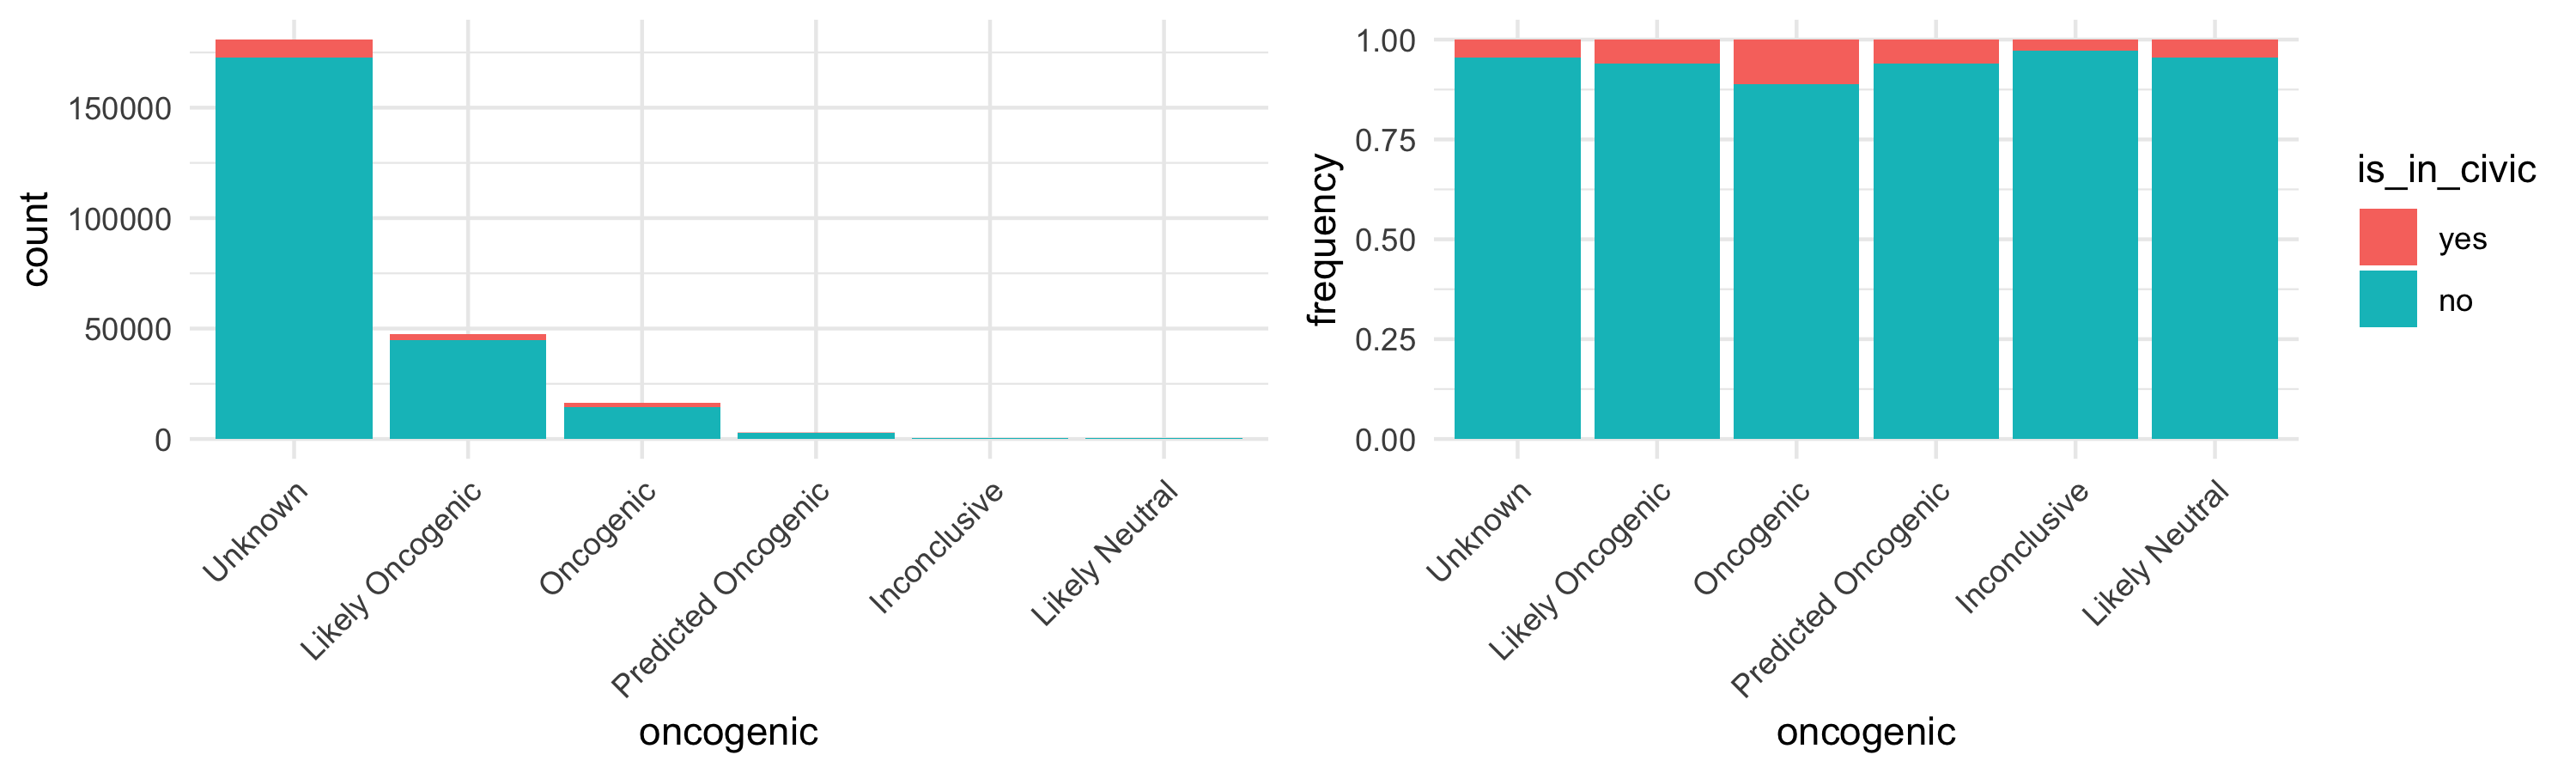

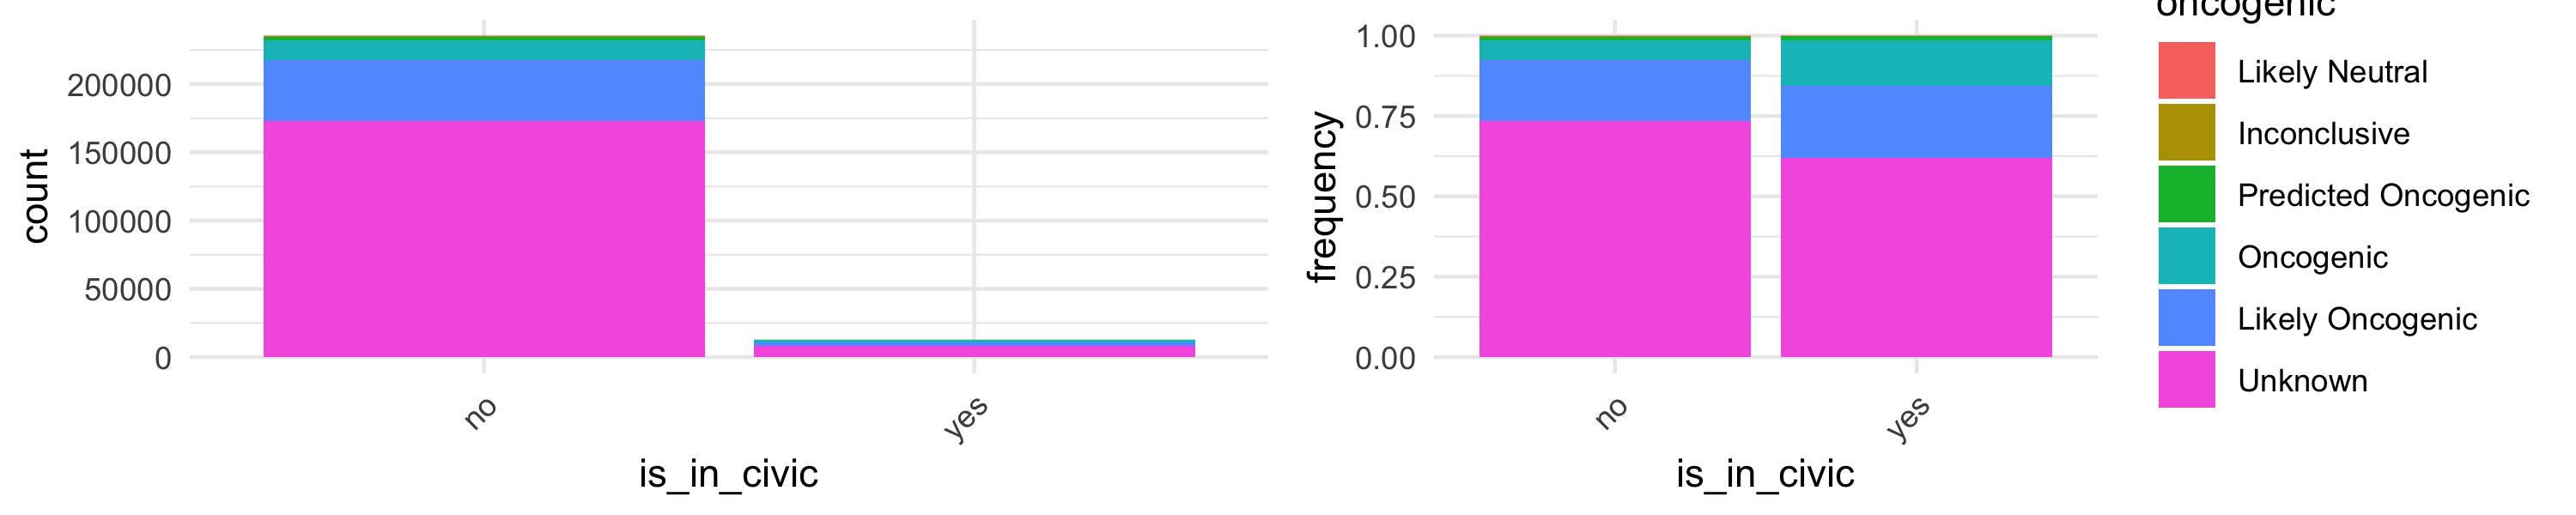

In [42]:
table(impact$is_in_civic)
table(impact$oncogenic)
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_civic", 10, 3)
plot_contingency_table_as_histograms(impact, "is_in_civic", "oncogenic", 10, 2)

## Cancer Genome Interpreter

### Get the raw data

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

In [43]:
cgi <- read.table("../../../data/other_databases/CGI_catalog_of_validated_oncogenic_mutations.tsv",
                  sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [47]:
nrow(cgi)
length(unique(cgi$gene))
colnames(cgi)

[1] 5601

[1] 247

[1] "gene"           "gdna"           "protein"        "transcript"    
[5] "info"           "context"        "cancer_acronym" "source"        
[9] "reference"

In [48]:
head(cgi, 10)

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
ABL1,chr9:g.133738306G>A,p.E236K,ENST00000318560,CSQN=Missense;codon_pos=133738306-133738307-133738308;ref_codon_seq=GAG;aliases=ENSP00000323315;source=Ensembl,somatic,CML,DoCM,PMID:21562040
ABL1,chr9:g.133738309A>G,p.M237V,ENST00000318560,"CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738309_133738311delATGinsGTA,chr9:g.133738309_133738311delATGinsGTC,chr9:g.133738309_133738311delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738325T>C,p.I242T,ENST00000318560,"CSQN=Missense;reference_codon=ATC;candidate_codons=ACA,ACG,ACT,ACC;candidate_mnv_variants=chr9:g.133738325_133738326delTCinsCA,chr9:g.133738325_133738326delTCinsCG,chr9:g.133738325_133738326delTCinsCT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738330A>G,p.M244V,ENST00000318560,"CSQN=Missense;codon_pos=133738330-133738331-133738332;ref_codon_seq=ATG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738330_133738332delATGinsGTA,chr9:g.133738330_133738332delATGinsGTC,chr9:g.133738330_133738332delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:20367437__PMID:21895409__PMID:25157968__PMID:12399961__PMID:12576318__PMID:23676790__PMID:18223278__PMID:12623848__PMID:21888027
ABL1,chr9:g.133738340A>G,p.K247R,ENST00000318560,"CSQN=Missense;reference_codon=AAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738340_133738341delAGinsGA,chr9:g.133738339_133738340delAAinsCG,chr9:g.133738339_133738341delAAGinsCGA,chr9:g.133738339_133738341delAAGinsCGC,chr9:g.133738339_133738341delAAGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738342C>G,p.L248V,ENST00000318560,"CSQN=Missense;codon_pos=133738342-133738343-133738344;ref_codon_seq=CTG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=CTG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738342_133738344delCTGinsGTA,chr9:g.133738342_133738344delCTGinsGTC,chr9:g.133738342_133738344delCTGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:18354488__PMID:20367437__PMID:25157968__PMID:21221851__PMID:17008892__PMID:12623848
ABL1,chr9:g.133738348G>A,p.G250R,ENST00000318560,"CSQN=Missense;reference_codon=GGG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_snv_variants=chr9:g.133738348G>C;candidate_mnv_variants=chr9:g.133738348_133738350delGGGinsAGA,chr9:g.133738348_133738350delGGGinsCGA,chr9:g.133738348_133738350delGGGinsCGC,chr9:g.133738348_133738350delGGGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738349G>A,p.G250E,ENST00000318560,"CSQN=Missense;reference_codon=GGG;candidate_codons=GAG,GAA;candidate_mnv_variants=chr9:g.133738349_133738350delGGinsAA;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;codon_pos=133738348-133738349-133738350;ref_codon_seq=GGG;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:21505103__PMID:20367437__PMID:21895409__PMID:22870928__PMID:25157968__PMID:11964322__PMID:23676790__PMID:12623848
ABL1,chr9:g.133738355A>G,p.Q252R,ENST00000318560,"CSQN=Missense;reference_codon=CAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738354_133738355delCAinsAG,chr9:g.133738355_133738356delAGinsGA,chr9:g.133738355_133738356delAGinsGC,chr9:g.133738355_133738356delAGinsGT,chr9:g.133738354_133738356delCAGinsAGA;aliases=ENSP

### Create keys to join the two dataframes and extract the features

We will join the database using the following keys: 
* `HGVSp_Short` for `impact`
* `protein` for `cgi`

In [35]:
civic$join_key <- paste(civic$chromosome, civic$start, civic$reference_bases, civic$variant_bases, sep = "_")
civic$join_key[civic$chromosome == "" |
               civic$start == "" |
               (civic$reference_bases == "" & civic$variant_bases   == "")] <- "no_key"

In [37]:
print_count_and_proportion(civic[civic$join_key == "no_key",], civic)

# delete the rows where we couldn't compute a key
civic <- civic[civic$join_key != "no_key",]

[1] "0 over 803 (0.00%)"

**Verification 1** The `protein` key are not unique:

In [54]:
length(unique(cgi$protein))
nrow(cgi)
repeated_key <- cgi %>% group_by(protein) %>% filter(n() > 1)
head(repeated_key[order(repeated_key$protein),], 5)

[1] 5069

[1] 5601

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
APC,chr5:g.112102884A>G,.,ENST00000257430,CSQN=SpliceAcceptorSNV;C2=SpliceAcceptorOfExon4_At_chr5:112102885;aliases=ENSP00000257430;source=Ensembl,germline,CANCER-PR,ClinVar,Clinvar:NM_000038.5(APC):c.221-2A>G AND Hereditary cancer-predisposing syndrome
APC,chr5:g.112111325G>C,.,ENST00000257430,CSQN=SpliceAcceptorSNV;C2=SpliceAcceptorOfExon5_At_chr5:112111325;aliases=ENSP00000257430;source=Ensembl,germline,CANCER-PR,ClinVar,Clinvar:NM_000038.5(APC):c.423-1G>C AND Hereditary cancer-predisposing syndrome
ATM,chr11:g.108098352A>C,.,ENST00000278616,CSQN=CdsStartSNV;C2=cds_start_at_chr11:108098352;aliases=ENSP00000278616;source=Ensembl,germline,CANCER-PR,ClinVar,Clinvar:NM_000051.3(ATM):c.1A>C (p.Met1Leu) AND Hereditary cancer-predisposing syndrome
ATM,chr11:g.108098352A>G,.,ENST00000278616,CSQN=CdsStartSNV;C2=cds_start_at_chr11:108098352;aliases=ENSP00000278616;source=Ensembl,germline,CANCER-PR,ClinVar,Clinvar:NM_000051.3(ATM):c.1A>G (p.Met1Val) AND Hereditary cancer-predisposing syndrome


In [55]:
# delete the repeated keys
cgi <- cgi[! cgi$protein %in% repeated_key$protein,]
nrow(cgi)

[1] 4828

**Verification 2** not every impact `HGVSp_Short` has an analoguous `protein` in `cgi`.

In [56]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$HGVSp_Short %in% cgi$protein] <- "yes"

### Results


    no    yes 
230612  17738 


       Inconclusive      Likely Neutral    Likely Oncogenic           Oncogenic 
                524                 384               47541               16233 
Predicted Oncogenic             Unknown 
               2840              180828 

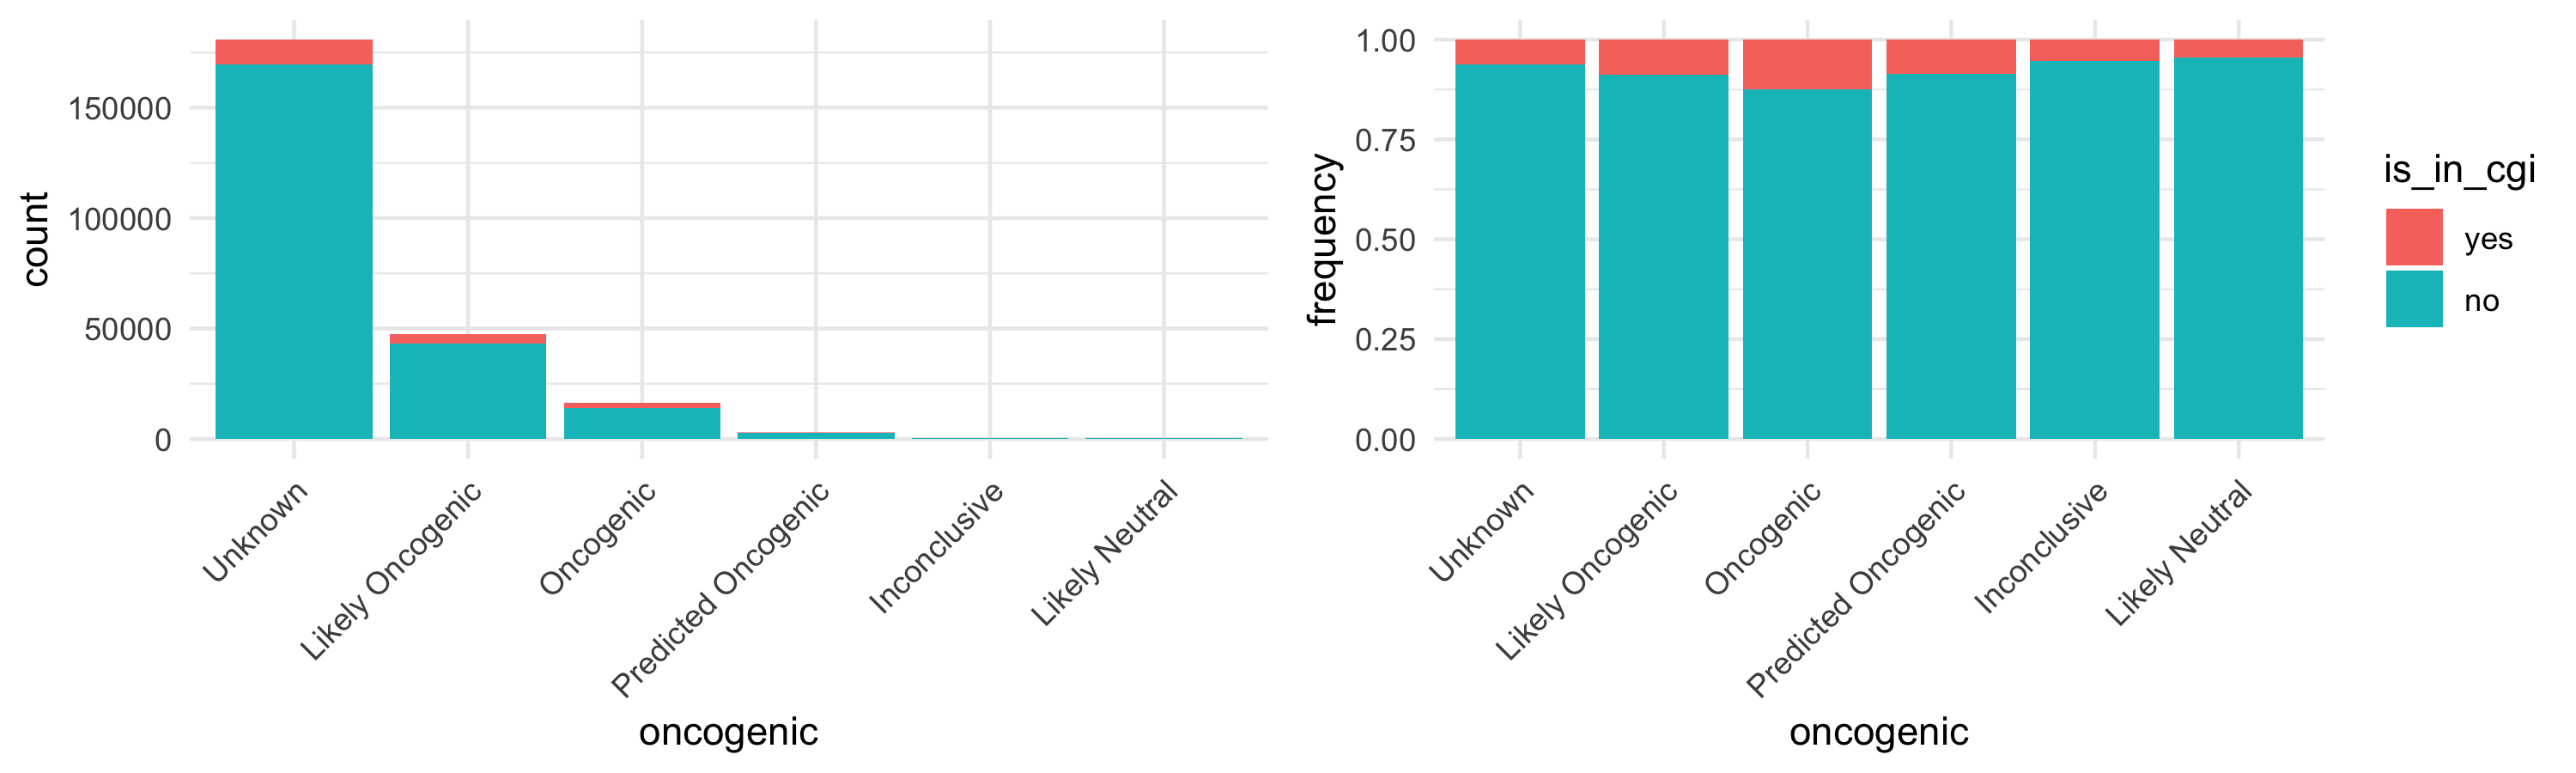

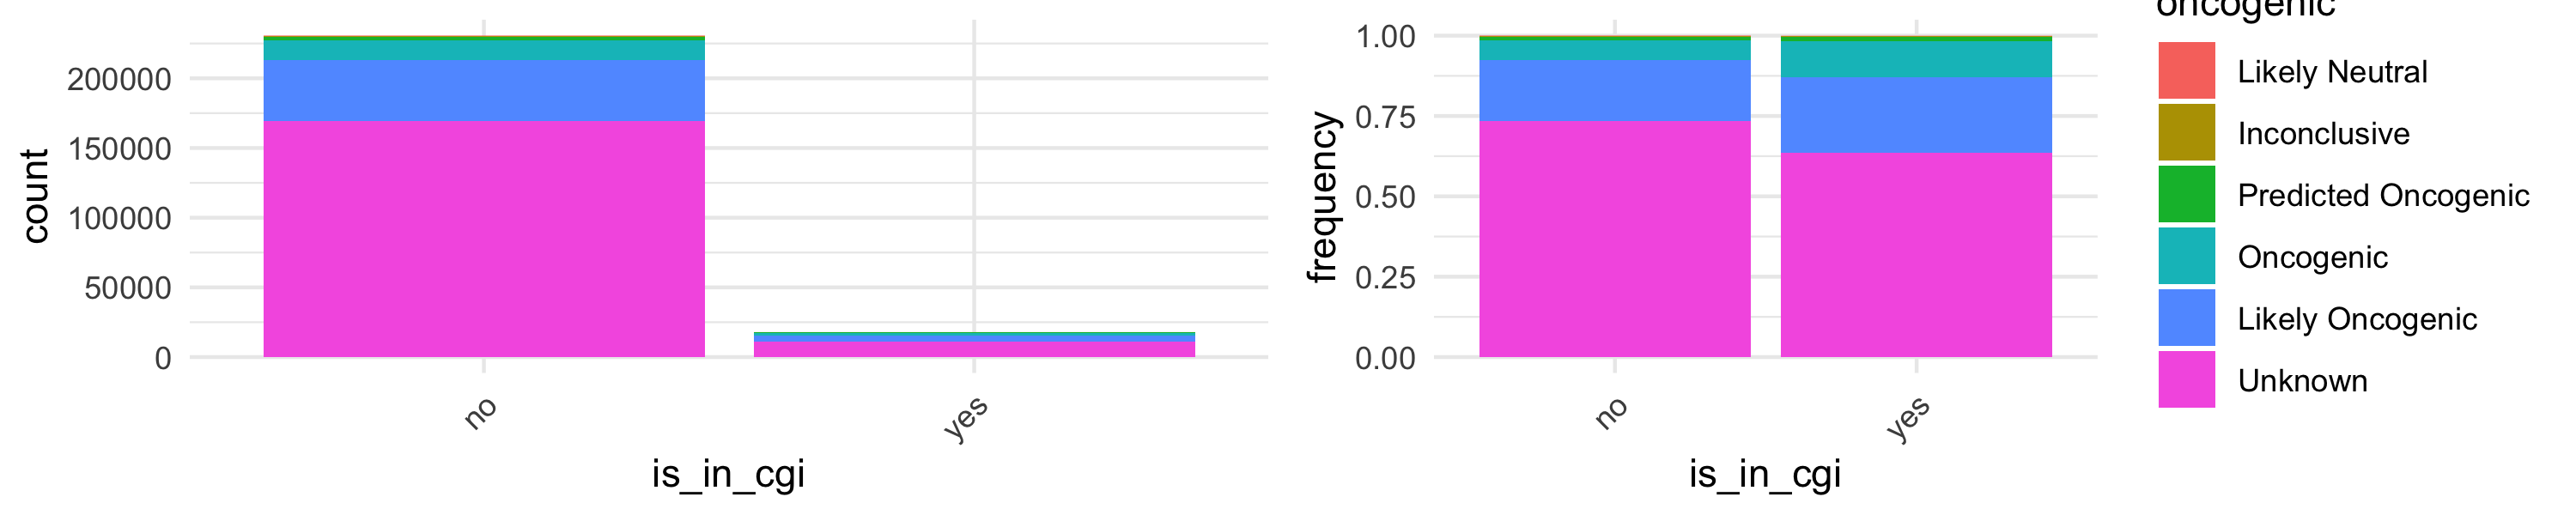

In [57]:
table(impact$is_in_cgi)
table(impact$oncogenic)
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_cgi", 10, 3)
plot_contingency_table_as_histograms(impact, "is_in_cgi", "oncogenic", 10, 2)

## Precision Medicine Knowledgebase

Data downloaded from https://pmkb.weill.cornell.edu under "Welcome to Precision Medicine Knowledgebase", 02/08/18 version.

In [59]:
install.packages("readxl", repos = "http://cran.us.r-project.org")


The downloaded binary packages are in
	/var/folders/8z/vf8s7np51tv6fpjv6yqvtdn93zds34/T//RtmpNTkCMj/downloaded_packages


In [58]:
library("readxl")

In [63]:
pmk <- read_excel("../../../data/other_databases/PMK_IPM_Knowledgebase_Interpretations_Complete_20180807-1922.xlsx")

In [65]:
nrow(pmk)
length(unique(pmk$Gene))
colnames(pmk)

[1] 553

[1] 153

[1] "Gene"            "Tumor Type(s)"   "Tissue Type(s)"  "Variant(s)"     
 [5] "Tier"            "Interpretations" "Citations"       "X__1"           
 [9] "X__2"            "X__3"            "X__4"            "X__5"           
[13] "X__6"            "X__7"            "X__8"            "X__9"           
[17] "X__10"           "X__11"           "X__12"           "X__13"          
[21] "X__14"           "X__15"           "X__16"           "X__17"          
[25] "X__18"           "X__19"           "X__20"

In [69]:
interesting_columns <- c(
"Gene",
"Tumor Type(s)",
"Tissue Type(s)",
"Variant(s)",
"Tier")

head(pmk[, interesting_columns], 10)

Gene,Tumor Type(s),Tissue Type(s),Variant(s),Tier
CSF3R,"Atypical Chronic Myeloid Leukemia, Chronic Neutrophilic Leukemia, Myeloproliferative Neoplasm","Blood, Bone Marrow","CSF3R T618I, CSF3R any nonsense, CSF3R any frameshift",1
MPL,"Essential Thrombocythemia, Myeloproliferative Neoplasm, Primary Myelofibrosis","Blood, Bone Marrow","MPL codon(s) 515 missense, MPL W515L, MPL W515K",1
JAK1,"Acute Myeloid Leukemia, T Lymphoblastic Leukemia/Lymphoma","Blood, Bone Marrow",NA,1
NRAS,"Acute Myeloid Leukemia, B Lymphoblastic Leukemia/Lymphoma, Chronic Myelomonocytic Leukemia, Myelodysplastic Syndrome","Blood, Bone Marrow",NA,1
NOTCH2,"Diffuse Large B Cell Lymphoma, Marginal Zone B Cell Lymphoma","Blood, Bone Marrow","NOTCH2 I2304fs, NOTCH2 exon(s) 34 frameshift",1
RIT1,"Acute Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Myelodysplastic Syndrome","Blood, Bone Marrow",RIT1 M90I,1
DNMT3A,"Acute Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Myelodysplastic Syndrome, Myeloproliferative Neoplasm, T Lymphoblastic Leukemia/Lymphoma","Blood, Bone Marrow",NA,1
FANCL,Myelodysplastic Syndrome,"Blood, Bone Marrow",NA,1
XPO1,Chronic Lymphocytic Leukemia,"Blood, Bone Marrow",NA,1
CXCR4,Lymphoplasmacytic Lymphoma,"Blood, Bone Marrow",NA,1


We stopped here.

## https://ckb.jax.org/about/index

## Others

In [ ]:
candl <- read.table("../../../data/other_databases/candl.csv",
                    sep = ",", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [ ]:
nrow(candl)
head(candl)
length(unique(candl$Gene))

In [ ]:
# creating the key
candl$join_key <- paste(civic$Chromosome, civic$DNA.Position, civic$Normal.AA, civic$Mutation.AA, sep = "_")
head(candl$join_ke)
candl$join_key[civic$chromosome == "" |
               civic$start == "" |
               (civic$reference_bases == "" & civic$variant_bases   == "")] <- "no_key"

In [ ]:
nrow(civic[civic$join_key == "no_key",])
nrow(civic)

# delete the rows where we couldn't compute a key
civic <- civic[civic$join_key != "no_key",]

In [ ]:
# check the unicity of `join_key`
length(unique(civic$join_key))
nrow(civic)

repeated_key <- civic %>% group_by(join_key) %>% filter(n() > 1)
repeated_key[order(repeated_key$join_key), interesting_columns]

In [ ]:
# delete the repeated keys
civic <- civic[! civic$join_key %in% repeated_key$join_key,]
nrow(civic)

In [ ]:
impact$is_in_civic <- "no"
impact$is_in_civic[impact$mut_key %in% civic$join_key] <- "yes"